# Gradient Boosting - Hyperparameter Tuning & Training (All Features)

In [3]:
# Core Libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

# Models and Calibration
from sklearn.ensemble import GradientBoostingClassifier # Or import XGBClassifier, LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Model Selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Scoring and Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    RocCurveDisplay,
    auc,
    brier_score_loss,
    make_scorer,
    PrecisionRecallDisplay,
    roc_auc_score
)

## 1. Load Data

In [7]:
try:
    X_train = pd.read_csv('../../data/processed/transformed/X_train_transform_scaled_resampled.csv') # Contains all features
    y_train = pd.read_csv('../../data/processed/transformed/y_train_transform_scaled_resampled.csv').values.ravel()
    X_val = pd.read_csv('../../data/processed/transformed/X_val_transform_scaled.csv') # Contains all features
    y_val = pd.read_csv('../../data/processed/transformed/y_val_transform.csv').values.ravel()
    X_test = pd.read_csv('../../data/processed/transformed/X_test_transform_scaled.csv') # Contains all features
    y_test = pd.read_csv('../../data/processed/transformed/y_test_transform.csv').values.ravel()
    print("Data loaded successfully.")
    print("X_train shape:", X_train.shape)
    print("X_validate shape:", X_val.shape)
    print("X_test shape:", X_test.shape)
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the data files are present in the correct paths.")
    # Exit or handle error appropriately
    exit() # Simple exit for script-like execution in notebook

Data loaded successfully.
X_train shape: (4762, 19)
X_validate shape: (984, 19)
X_test shape: (984, 19)


## 2. Define Model and Hyperparameter Space

In [5]:
# Define the base model (using scikit-learn's GradientBoostingClassifier here)
gb = GradientBoostingClassifier(random_state=42)

# Define the parameter distribution for Randomized Search
# Note: Different parameters than RandomForest
param_distributions = {
    'n_estimators': randint(100, 601),           # Number of boosting stages
    'learning_rate': uniform(0.01, 0.2),         # Learning rate shrinks contribution of each tree (e.g., 0.01 to 0.21)
    'max_depth': randint(3, 11),                 # Max depth of individual trees (e.g., 3 to 10)
    'subsample': uniform(0.7, 0.3),              # Fraction of samples for fitting trees (e.g., 0.7 to 1.0)
    'min_samples_split': randint(2, 11),        # Min samples to split node
    'min_samples_leaf': randint(1, 5),          # Min samples per leaf node
    'max_features': ['sqrt', 'log2', None]       # Number of features for best split
}

## 3. Setup Cross-Validation and Randomized Search

In [6]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(brier_score_loss, needs_proba=True, greater_is_better=False)
random_search = RandomizedSearchCV(
    estimator=gb, # Use the GB estimator
    param_distributions=param_distributions,
    n_iter=50,
    cv=cv_strategy,
    scoring=scorer,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

## 4. Run Hyperparameter Search

In [8]:
print("Starting Randomized Search CV for Gradient Boosting (All Features)...")
random_search.fit(X_train, y_train)
print("Search complete.")

Starting Randomized Search CV for Gradient Boosting (All Features)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.


## 5. Analyze Search Results

In [9]:
print(f"Best Parameters found: {random_search.best_params_}")
print(f"Best Brier Score: {abs(random_search.best_score_):.4f}")
best_gb_all_features = random_search.best_estimator_

Best Parameters found: {'learning_rate': 0.16111022770860975, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 286, 'subsample': 0.9084354799119113}
Best Brier Score: 0.0209


## 6. Final Evaluation on Test Set

In [10]:
print("\n--- Evaluating Best Model on Test Set (All Features) ---")
y_pred_test = best_gb_all_features.predict(X_test)
y_pred_proba_test = best_gb_all_features.predict_proba(X_test)[:, 1]
# ... rest of evaluation code (classification_report, AUCs) ...
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
pr_auc_test = average_precision_score(y_test, y_pred_proba_test)
print(f"Test ROC AUC Score: {roc_auc_test:.4f}")
print(f"Test Precision-Recall AUC Score: {pr_auc_test:.4f}")
print(f"Test Brier Score: {brier_score_loss(y_test, y_pred_proba_test):.4f}")


--- Evaluating Best Model on Test Set (All Features) ---
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       794
           1       0.87      0.89      0.88       190

    accuracy                           0.95       984
   macro avg       0.92      0.93      0.93       984
weighted avg       0.95      0.95      0.95       984

Test ROC AUC Score: 0.9875
Test Precision-Recall AUC Score: 0.9494
Test Brier Score: 0.0390


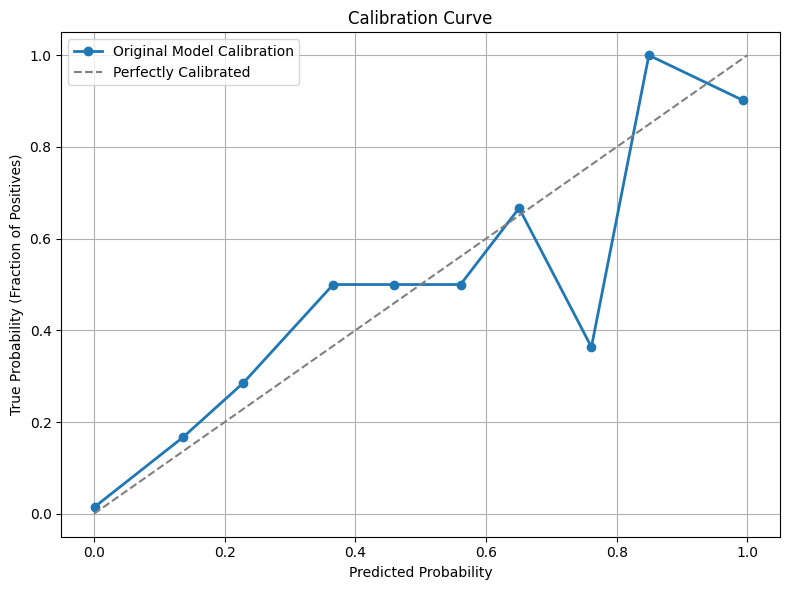

In [19]:
# Compute calibration curve
prob_true_raw, prob_pred_raw = calibration_curve(y_test, y_pred_proba_test, n_bins=10, strategy='uniform')
# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_raw, prob_true_raw, marker='o', label='Original Model Calibration', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability (Fraction of Positives)")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Plot Metrics (Test Set)

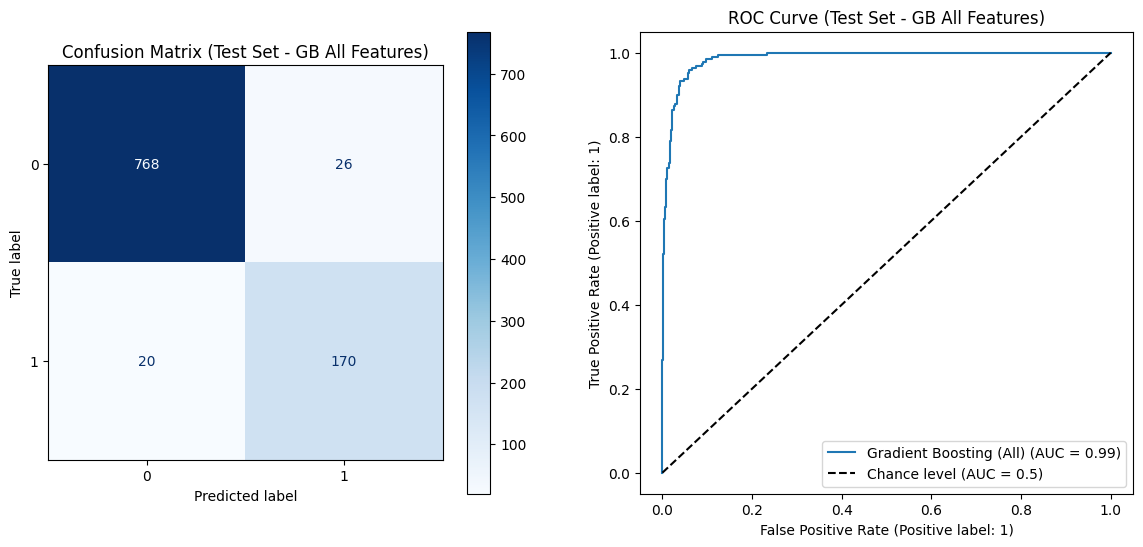

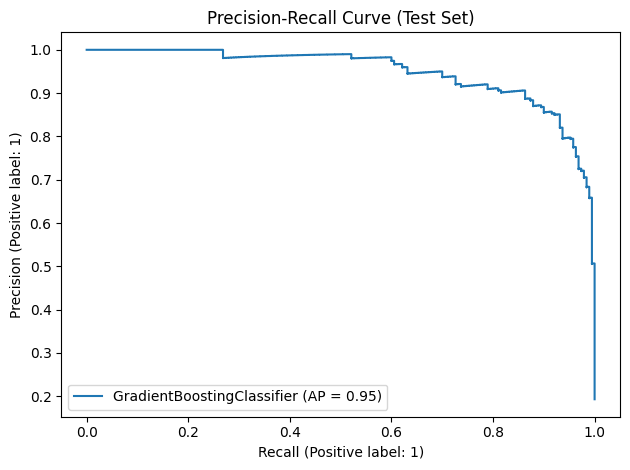

In [11]:
# ... plotting code using best_gb_all_features, X_test, y_test ...
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ConfusionMatrixDisplay.from_estimator(best_gb_all_features, X_test, y_test, ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix (Test Set - GB All Features)')
RocCurveDisplay.from_estimator(best_gb_all_features, X_test, y_test, ax=axes[1], name='Gradient Boosting (All)')
axes[1].plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
axes[1].set_title('ROC Curve (Test Set - GB All Features)')
axes[1].legend()
PrecisionRecallDisplay.from_estimator(best_gb_all_features, X_test, y_test)
plt.title('Precision-Recall Curve (Test Set)')
plt.tight_layout()
plt.show()

## 9. Save the Final Model

In [20]:
# --- Placeholder: Define save path ---
model_save_path = '../../models/gb_model_all_features_transformed.pkl'
joblib.dump(best_gb_all_features, model_save_path)
print(f"Best Gradient Boosting model (all features with transformation) saved to {model_save_path}")

Best Gradient Boosting model (all features with transformation) saved to ../../models/gb_model_all_features_transformed.pkl
